# 2. CML processing 
In this notebook cml are processed according to the following steps:
* calculate total loss
* simple quality control
* Wet&Dry Classification
* baseline computation 
* rain-induced attenuation
* rain rate estimate

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pycomlink as pycml
import pandas as pd
from scipy.ndimage import binary_dilation

## 2.1 CML processing & quality control functions

In [2]:
def cml_preprocessing(ds_cmls_input):
    '''
    compute total loss and remove poorly performing cmls
    '''
    ds_cmls = ds_cmls_input.copy()

    # calculate total loss
    ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

    # flag cmls with strong diurnal cycles
    qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1
    
    # flag cmls with very noisy periods
    qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.35

    filtered = ds_cmls.where(qc_diurnalcicle | qc_noisyperiods, drop=True)
    ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)
    ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)
    
    return ds_cmls, filtered

In [3]:
def wetdry_radarbased(ds_cmls, radar_along_cml, rad_freq):
   '''
   perform wet/dry classification based on rad_freq min radar rainfall along cml
   '''
   # preparation of the datasets
   timeseq = pd.date_range(ds_cmls.time.values[0], ds_cmls.time.values[-1], freq="min")
   ds_cmls = ds_cmls.reindex({"time": timeseq})
   radar_along_cml = radar_along_cml.transpose("cml_id", "time")
   radar_along_cml = radar_along_cml.reindex({"time": timeseq})
   radar_along_cml = radar_along_cml.reindex({"cml_id": ds_cmls.cml_id})
   #initialize
   wet = xr.zeros_like(ds_cmls["tl"], dtype=bool)
   # create mask == True when radar > 0.01
   radar_along_cml['mask'] = (radar_along_cml.rainfall_amount > 0.01).astype('int')
   #expand mask before and after
   expand_before = rad_freq  
   expand_after = 5    
   mask_np = radar_along_cml.mask.values
   # expansion with binary_dilation on rows(cml_id)
   expanded_mask_np = np.array([
      binary_dilation(row, structure=np.ones(expand_before + 1 + expand_after), origin=expand_after)
      for row in mask_np
   ])
   expanded_mask_xr = xr.DataArray(expanded_mask_np.astype(int), 
                                   coords=radar_along_cml.mask.coords, 
                                   dims=radar_along_cml.mask.dims)
   wet.loc[{"sublink_id": ["channel1","channel2"]}] = expanded_mask_xr
   return wet 

In [4]:
def cml_processing(ds_cmls_input, radar_along_cml, rad_freq):
    '''
    cml processing
    '''
    ds_cmls = ds_cmls_input.copy()

    # calculate wet periods
    ds_cmls['wet'] = wetdry_radarbased(ds_cmls, radar_along_cml, rad_freq)
    
    # calculate baseline
    ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
        trsl=ds_cmls.tl,
        wet=ds_cmls.wet,
        n_average_last_dry=5,
    )    

    # calculate wet antenna effect
    ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
    ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
    ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
        A_obs=ds_cmls.A_obs,
        f_Hz=ds_cmls.frequency * 1e6,
        pol=ds_cmls.polarization.data,
        L_km=ds_cmls.length / 1000,
        A_max=6,
        zeta=0.7,  
        d=0.15, 
    )
    
    # calculate attenuation caused by rain and remove negative attenuation
    ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
    ds_cmls["A"].data[ds_cmls.A < 0] = 0
    # derive rain rate via the k-R relation
    ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
        A=ds_cmls.A,
        L_km=ds_cmls.length.astype(float) / 1000,  
        f_GHz=ds_cmls.frequency / 1000,  
        pol=ds_cmls.polarization,
    )
    
    #calculate 1minute acc. precipitation  
    ds_cmls['R_acc'] = ds_cmls['R']/60
    return ds_cmls

## 2.2 OpenMRG processing

In [5]:
#open dataset
ds_cmls = xr.open_dataset('data/andersson_2022_OpenMRG/openMRG_cml.nc')
radar_along_cml = xr.open_dataset('data/andersson_2022_OpenMRG/radar/radar_along_cml.nc')

In [6]:
# Resample to 1 minute temporal resolution
ds_cmls = ds_cmls.resample(time="1min").first(skipna=True)
# change sublink identifiers names 
ds_cmls = ds_cmls.assign_coords(sublink_id = np.array(['channel1', 'channel2'])) 

In [7]:
# compute attenuation + QC
ds_cmls, filtered = cml_preprocessing(ds_cmls)

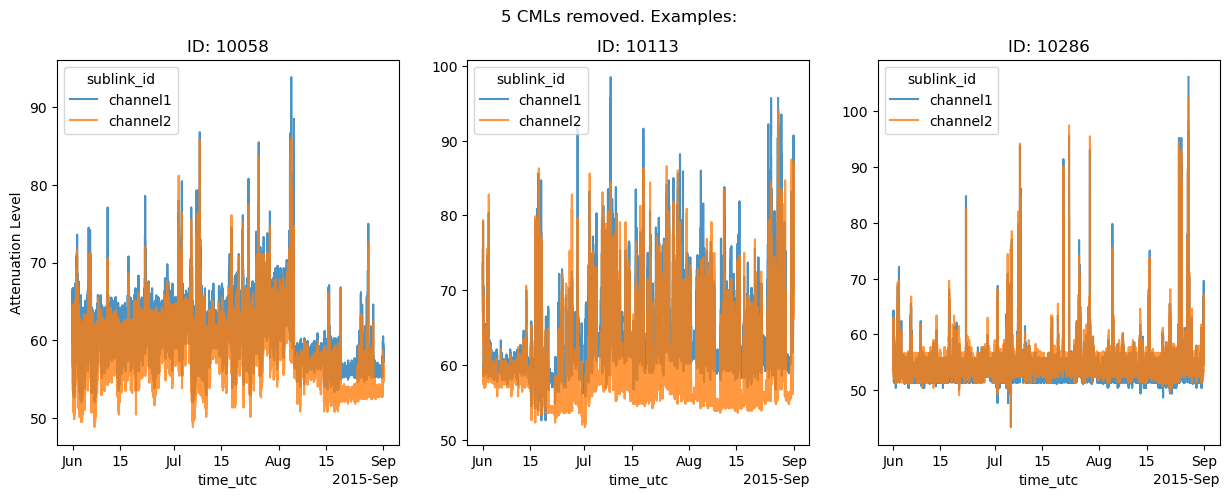

In [8]:
# plot filtered cmls
fig, ax=plt.subplots(1,3, figsize=(15,5))
for i in np.arange(3):
    filtered.tl.isel(cml_id=i).plot.line(x='time', ax=ax[i], alpha=0.8) 
    ax[i].set_title('ID: '+str(filtered.cml_id.values[i]))
    ax[i].set_ylabel('')
ax[0].set_ylabel('Attenuation Level')
plt.suptitle(str(len(filtered.cml_id))+' CMLs removed. Examples:')
plt.show()

In [9]:
# cml processing
ds_cmls = cml_processing(ds_cmls, radar_along_cml, rad_freq=5) 

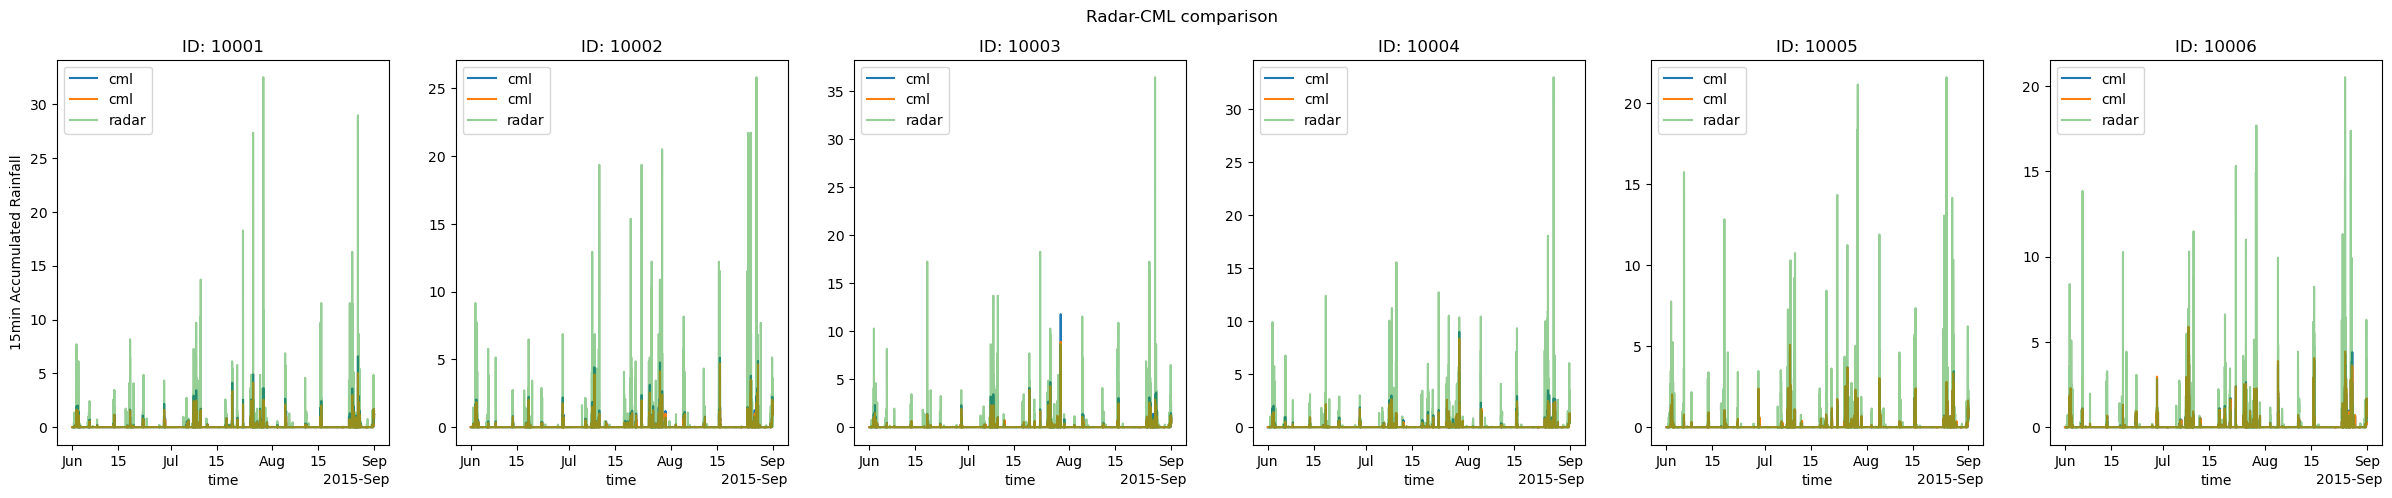

In [10]:
# plot some examples
test_plot = ds_cmls.R_acc.rolling(time=15, center=False).sum()
n_cmls_toplot = 6

fig, ax=plt.subplots(1,n_cmls_toplot, figsize=(n_cmls_toplot*5,5))
for i in np.arange(n_cmls_toplot):
    cml_id_i = ds_cmls.cml_id.values[i]
    test_plot.sel(cml_id=cml_id_i).plot.line(x='time', ax=ax[i], label='cml') 
    radar_along_cml.rainfall_amount.sel(cml_id=cml_id_i).plot.line(x='time', 
                                                               ax=ax[i], 
                                                               alpha=0.5,
                                                               label='radar') 
    ax[i].set_title('ID: '+str(int(ds_cmls.cml_id.values[i])))
    ax[i].set_ylabel('')
    ax[i].legend()
ax[0].set_ylabel('15min Accumulated Rainfall')
plt.suptitle('Radar-CML comparison')
plt.show()

In [11]:
# saving output
ds_cmls.to_netcdf('data/processed_cml_OpenMRG.nc')

## 2.3 OpenRainER processing

In [12]:
#open dataset
ds_cmls = xr.open_dataset('data/covi_2024_OpenRainER/OpenRainER_cmls.nc')
radar_along_cml = xr.open_dataset('data/covi_2024_OpenRainER/RADadj_along_cml.nc')

In [13]:
# compute attenuation + QC
ds_cmls, filtered = cml_preprocessing(ds_cmls)

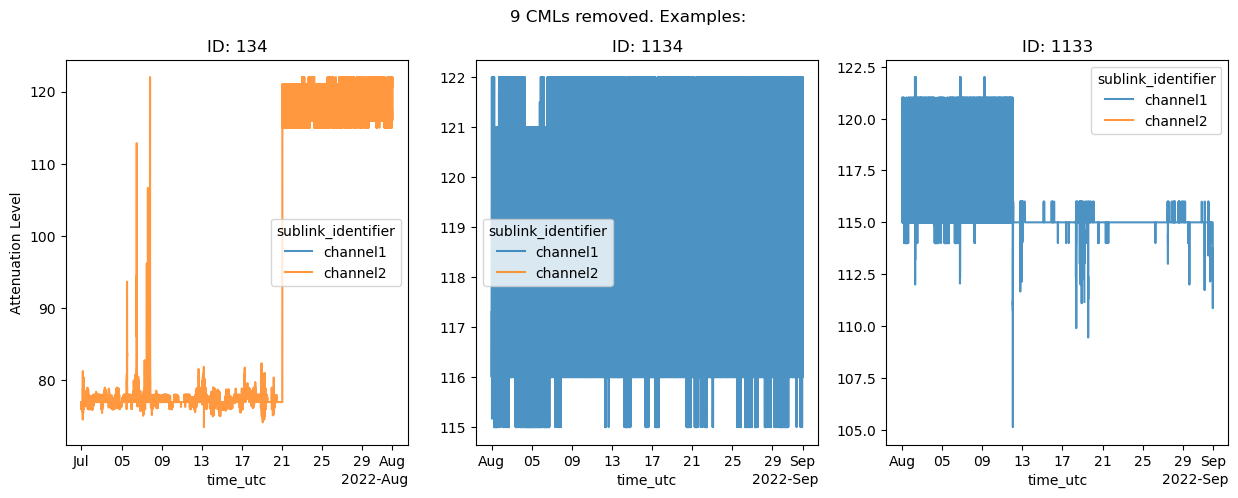

In [14]:
# plot filtered cmls
fig, ax=plt.subplots(1,3, figsize=(15,5))
for i in np.arange(3):
    filtered.tl.isel(cml_id=i).plot.line(x='time', ax=ax[i], alpha=0.8) 
    ax[i].set_title('ID: '+str(filtered.cml_id.values[i]))
    ax[i].set_ylabel('')
ax[0].set_ylabel('Attenuation Level')
plt.suptitle(str(len(filtered.cml_id))+' CMLs removed. Examples:')
plt.show()

In [15]:
# cml processing
ds_cmls = cml_processing(ds_cmls, radar_along_cml, rad_freq=15) 

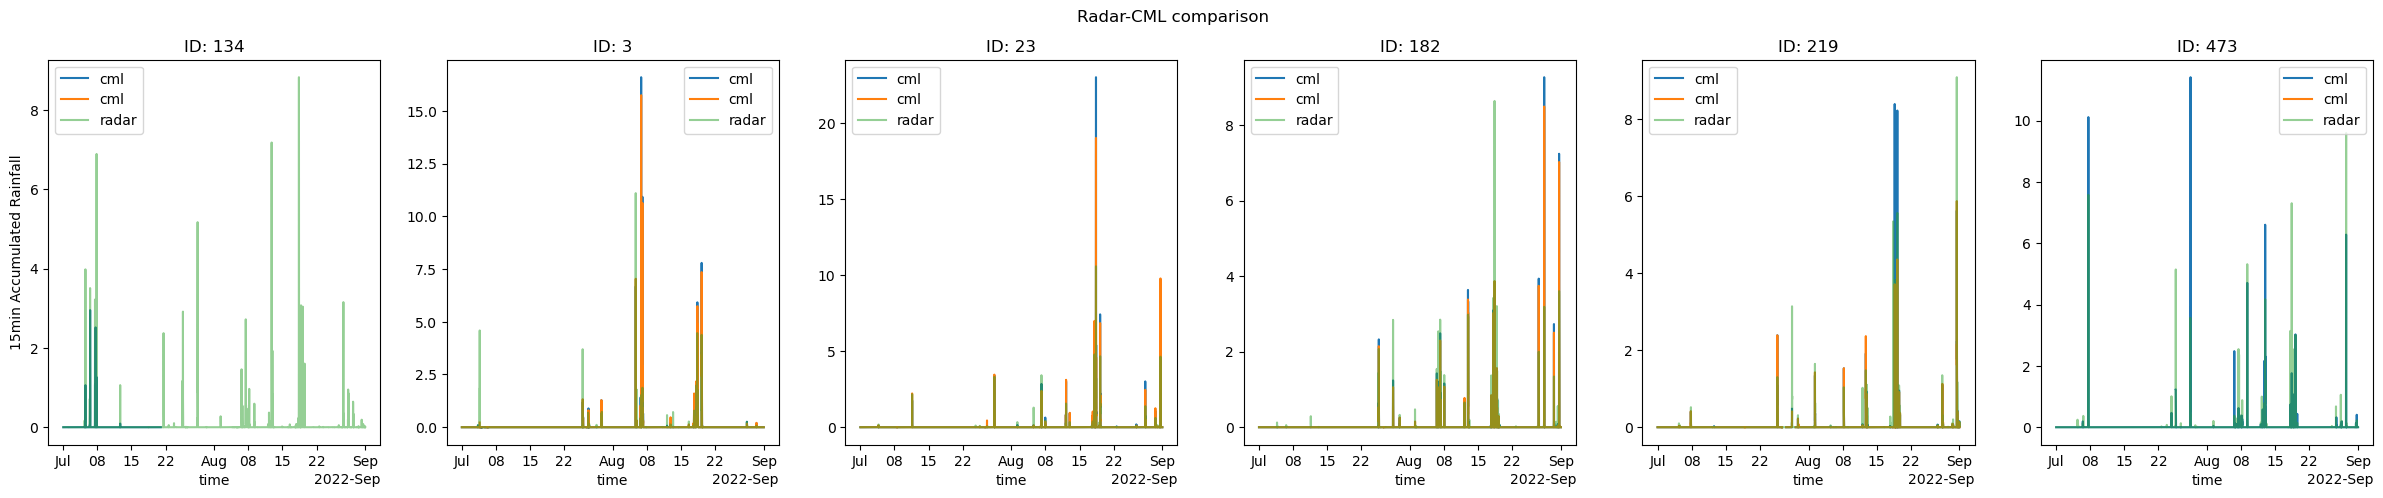

In [16]:
# plot some examples
test_plot = ds_cmls.R_acc.rolling(time=15, center=False).sum()
n_cmls_toplot = 6

fig, ax=plt.subplots(1,n_cmls_toplot, figsize=(n_cmls_toplot*5,5))
for i in np.arange(n_cmls_toplot):
    cml_id_i = ds_cmls.cml_id.values[i]
    test_plot.sel(cml_id=cml_id_i).plot.line(x='time', ax=ax[i], label='cml') 
    radar_along_cml.rainfall_amount.sel(cml_id=cml_id_i).plot.line(x='time', 
                                                               ax=ax[i], 
                                                               alpha=0.5,
                                                               label='radar') 
    ax[i].set_title('ID: '+str(int(ds_cmls.cml_id.values[i])))
    ax[i].set_ylabel('')
    ax[i].legend()
ax[0].set_ylabel('15min Accumulated Rainfall')
plt.suptitle('Radar-CML comparison')
plt.show()

In [17]:
# saving output
ds_cmls.to_netcdf('data/processed_cml_OpenRainER.nc')